# Exposed and Infected class calculations

This notebook implements methods to calculate exposed and infected classes based on death and confirmed case numbers

In [52]:
import pandas as pd
import numpy as np
from scipy.stats.distributions import gamma

from epimodel import read_csv
# This is not stable enough to be usable
#from modeling.nowcasting.nowcasting import exp_model

In [443]:
csse_ds = read_csv("../../data/johns-hopkins.csv")

csse_ds = csse_ds.loc[csse_ds.index.dropna(),:]
csse_ds = csse_ds.loc[~(csse_ds.index.get_level_values(0)=='CA'),:]

This is the infection to death distribution from the [ICL Paper](https://www.imperial.ac.uk/media/imperial-college/medicine/mrc-gida/2020-03-30-COVID19-Report-13.pdf)

In [54]:
ICL_ITD = gamma(1/0.45**2,0,18.8*0.45**2)

DEATHS_DAYS = np.array([ICL_ITD.cdf(a+1)-ICL_ITD.cdf(a) for a in range(40)])

In [431]:
# see heading "Align Confirmed Cases" below

def transformCases(s):
    shifted = s.diff().shift(-7)
    return shifted


# This isn't very accurate, and a better nowcast might be useful.
# However, wherever we use it we then take a convolutions with a distributions with 
# very small weight on the relevant days, so the poor fit is acceptable.

def fillforward(orig,fill=7, pred=7):
    s = orig.copy()
    data_x = np.linspace(1,pred,pred)
    data_pred = np.linspace(pred+1,pred+1+fill,fill)
    try:
        s[-fill:] = np.poly1d(np.polyfit(data_x,
                                       s[-(pred+fill):-fill],1))(data_pred)
    except ValueError:
        print('Invalid data for linear fit', s[-(pred+fill):-fill])
        # In this case, we really don't know what cases are likely to do
        s[-fill:] = np.nan
        return s
    return s

# see heading "Comparison of Expected Deaths" below


def expectedDeaths(s,fatality=0.008):
    cv = np.convolve(fillforward(s),DEATHS_DAYS,'valid')
    pw = len(s)-len(cv)
    return fatality*np.pad(cv,(pw,0),"constant",constant_values=np.nan)

## see heading "Recovered, Infectious and Exposed Classes" below


def lik_r(i,mu=0.5):
    return np.exp(-mu*i)

norm = lik_r(np.arange(1,100)).sum()

def r(i):
    return lik_r(i)/norm

def R(ti):
    ti_pad = np.pad(ti,(40,0),'constant',constant_values=0)
    cv = np.convolve(ti_pad,r(np.arange(1,42)),'valid')
    pw = len(ti)-len(cv)
    return np.pad(cv,(pw,0),"constant",constant_values=0)

norm_I = lik_r(np.arange(1,100),0.2).sum()

def inf(i):
    return lik_r(i,0.2)/norm_I

def E2I(ever_exposed):
    ee_pad = np.pad(ever_exposed,(40,0),'constant',constant_values=0)
    cv = np.convolve(ee_pad,inf(np.arange(1,42)),'valid')
    pw = len(ever_exposed)-len(cv)
    return np.pad(cv,(pw,0),"constant",constant_values=0)

# Calculate ascertainment, true infection rates, exposed and infectious classes and add as new columns
# Returns a much smaller dataframe, as 

def filtered_mean(m,indices):
    return m[indices].mean()

def ascertainment(csse_ds,fatality = 0.008):
    csse_df = csse_ds.copy()
    csse_df['New confirmed shifted'] = csse_df['Confirmed'].groupby(level=0).transform(transformCases)
    csse_df['New deaths'] = csse_df['Deaths'].groupby(level=0).transform(lambda x: x.diff())
    
    g = csse_df.groupby(level=0)
    
    csse_df['Expected deaths'] = g['New confirmed shifted'].transform(expectedDeaths,fatality=fatality)
    
    indices = csse_df['New deaths']>=5
    
    csse_df['Ascertainment'] = np.nan
    
    csse_df.loc[indices,'Ascertainment'] = pd.to_numeric(csse_df.loc[indices,'Expected deaths']
                                            /csse_df.loc[indices,'New deaths'])
    
    csse_df['New cases true'] = (csse_df['New confirmed shifted']
                                             /csse_df.groupby(level=0)['Ascertainment'].transform(filtered_mean,indices))

    g2 = csse_df.groupby(level=0)
    csse_df['Exposed'] = g2['New cases true'].transform(np.cumsum) - g2['New cases true'].transform(lambda x: np.cumsum(E2I(x)))
    csse_df['Recovered'] = g2['New cases true'].transform(lambda x: np.cumsum(R(E2I(x))))
    csse_df['Infectious'] = g2['New cases true'].transform(lambda x: np.cumsum(E2I(x))) - csse_df['Recovered']
    return csse_df

## Align confirmed cases

The first step is to calculate new infections timeshifted back by 7 days. The figure 7 comes from:
 - 5.5 days infection-to-symptoms (https://docs.google.com/spreadsheets/d/1yzVSp71jiCsoD_L6sXchfg8L9OF0tGHWEnCdfvF73Ac/edit#gid=1242721729)
 - 4 days symptoms-to-confirmation (also https://docs.google.com/spreadsheets/d/1yzVSp71jiCsoD_L6sXchfg8L9OF0tGHWEnCdfvF73Ac/edit#gid=1242721729)
 - Subtract two days as exponential growth means that fast confirmations will be overrepresented
 
We could in principle calculate this properly (as below), but it is less crucial than calculating infection to death properly.

We'd like to fill in the last 7 days with nowcasting, but it's too unstable to be usable right now.

In [56]:
csse_demo = csse_ds.copy()

csse_demo['New Confirmed Shifted'] = csse_demo['Confirmed'].groupby(level=0).transform(transformCases)
csse_demo['New Deaths'] = csse_demo['Deaths'].groupby(level=0).transform(lambda x: x.diff())

csse_demo.loc['IT'][-24:]

,Recovered,Confirmed,Deaths,Active,New Confirmed Shifted,New Deaths
Date,,,,,,
2020-03-15 00:00:00+00:00,2335.0,24747.0,1809.0,20603.0,5560.0,368.0
2020-03-16 00:00:00+00:00,2749.0,27980.0,2158.0,23073.0,4789.0,349.0
2020-03-17 00:00:00+00:00,2941.0,31506.0,2503.0,26062.0,5249.0,345.0
2020-03-18 00:00:00+00:00,4025.0,35713.0,2978.0,28710.0,5210.0,475.0
2020-03-19 00:00:00+00:00,4440.0,41035.0,3405.0,33190.0,6203.0,427.0
2020-03-20 00:00:00+00:00,4440.0,47021.0,4032.0,38549.0,5909.0,627.0
2020-03-21 00:00:00+00:00,6072.0,53578.0,4825.0,42681.0,5974.0,793.0
2020-03-22 00:00:00+00:00,7024.0,59138.0,5476.0,46638.0,5217.0,651.0
2020-03-23 00:00:00+00:00,7024.0,63927.0,6077.0,50826.0,4050.0,601.0


## Comparison of Expected Deaths

The number of deaths on day $i$ should be
$$ d_i = f \sum_j p_{i-j} t_j $$
where $f$ is the infection fatality rate, $p_k$ is the probability of dieing $k$ days after being infected and $t_j$ is the true number of cases on day $j$.

Suppose that there is a fixed ascertainment rate $a$ such that confirmed cases $c_j=a t_{j-7}$ for all $j$. Then 

$$ a = \frac{f\sum_j p_{i-j} c_{j+7}}{d_{i}} $$

**Note** This is actually *lagged* ascertainment rate - it asks "what fraction of new cases today are detected 7 days later". I don't directly estimate an instantaneous ascertainment rate as this is very sensitive to the short term trajectory of infections, which, as I note above, I can't yet forecast. What we can in fact calculate is:

$$ t_{i-7} = \frac{c_i}{a}  $$

Th

In [41]:
g = csse_demo.groupby(level=0)

csse_demo['Expdeaths'] = g['New Confirmed Shifted'].transform(expectedDeaths,fatality=0.008)
csse_demo['Ascertainment'] = csse_demo['Expdeaths']/csse_demo['New Deaths']

According to this method, ascertainment in Italy may be rising slightly

In [28]:
csse_demo.loc['IT'][-40:]

,Recovered,Confirmed,Deaths,Active,New Confirmed Shifted,New Deaths,Expdeaths,Ascertainment
Date,,,,,,,,
2020-02-28 00:00:00+00:00,46.0,888.0,21.0,821.0,778.0,4.0,NaN,NaN
2020-02-29 00:00:00+00:00,46.0,1128.0,29.0,1053.0,1247.0,8.0,NaN,NaN
2020-03-01 00:00:00+00:00,83.0,1694.0,34.0,1577.0,1492.0,5.0,0.638381,0.127676
2020-03-02 00:00:00+00:00,149.0,2036.0,52.0,1835.0,1797.0,18.0,0.810308,0.045017
2020-03-03 00:00:00+00:00,160.0,2502.0,79.0,2263.0,977.0,27.0,1.019339,0.037753
2020-03-04 00:00:00+00:00,276.0,3089.0,107.0,2706.0,2313.0,28.0,1.272657,0.045452
2020-03-05 00:00:00+00:00,414.0,3858.0,148.0,3296.0,0.0,41.0,1.575543,0.038428
2020-03-06 00:00:00+00:00,523.0,4636.0,197.0,3916.0,5198.0,49.0,1.930017,0.039388
2020-03-07 00:00:00+00:00,589.0,5883.0,233.0,5061.0,3497.0,36.0,2.337004,0.064917


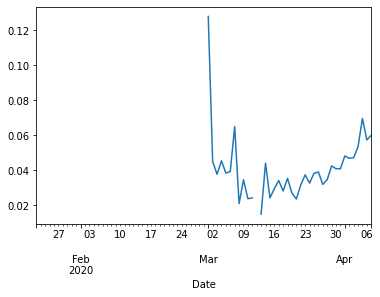

In [29]:
csse_demo.loc['IT','Ascertainment'].plot()

While ascertainment in Brazil looks steady

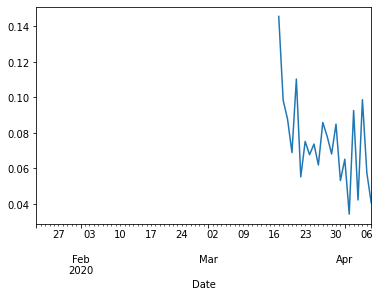

In [30]:
csse_demo.loc['BR','Ascertainment'].plot()

# Filter out small numbers of deaths

The method doesn't work well with small numbers of deaths per day. Fully Bayesian treatment probably handles this case better

In [31]:
csse_demo[(csse_demo['Ascertainment']<np.inf)&(csse_demo['Ascertainment']>1)]

Recovered  Confirmed  Deaths   Active  \
Code  Date                                                               
AT    2020-03-25 00:00:00+00:00        9.0     5588.0    30.0   5549.0   
CH    2020-03-18 00:00:00+00:00       15.0     3028.0    28.0   2985.0   
      2020-03-24 00:00:00+00:00      131.0     9877.0   122.0   9624.0   
DE    2020-03-15 00:00:00+00:00       46.0     5795.0    11.0   5738.0   
      2020-03-18 00:00:00+00:00      105.0    12327.0    28.0  12194.0   
ES    2020-03-12 00:00:00+00:00      183.0     2277.0    55.0   2039.0   
IL    2020-03-30 00:00:00+00:00      161.0     4695.0    16.0   4518.0   
KR    2020-03-01 00:00:00+00:00       30.0     3736.0    17.0   3689.0   
      2020-03-07 00:00:00+00:00      135.0     7041.0    44.0   6862.0   
      2020-03-10 00:00:00+00:00      247.0     7513.0    54.0   7212.0   
MY    2020-04-06 00:00:00+00:00     1241.0     3793.0    62.0   2490.0   
      2020-04-07 00:00:00+00:00     1321.0     3963.0    63.0   2579.0   
PK    2020-04-04 00:00:00+00:00      131.0     2818.0    41.0   2646.0   
RU    2020-04-05 00:00:00+00:00      355.0     5389.0    45.0   4989.0   
      2020-04-06 00:00:00+00:00      406.0     6343.0    47.0   5890.0   
US-FL 2020-04-01 00:00:00+00:00        NaN     6956.0    87.0      NaN   
US-IL 2020-04-07 00:00:00+00:00        NaN    12271.0   308.0      NaN   

                                 New Confirmed Shifted  New Deaths  Expdeaths  \
Code  Date                                                                      
AT    2020-03-25 00:00:00+00:00                  531.0         2.0   2.150260   
CH    2020-03-18 00:00:00+00:00                 1020.0         1.0   1.359328   
      2020-03-24 00:00:00+00:00                  683.0         2.0   3.525729   
DE    2020-03-15 00:00:00+00:00                 2660.0         2.0   2.411760   
      2020-03-18 00:00:00+00:00                 4337.0         4.0   4.756161   
ES    2020-03-12 00:00:00+00:00                 4053.0         1.0   1.411951   
IL    2020-03-30 00:00:00+00:00                  474.0         1.0   1.762214   
KR    2020-03-01 00:00:00+00:00                  273.0         1.0   1.345299   
      2020-03-07 00:00:00+00:00                  107.0         2.0   2.533591   
      2020-03-10 00:00:00+00:00                   84.0         1.0   2.760527   
MY    2020-04-06 00:00:00+00:00                    NaN         1.0   1.147667   
      2020-04-07 00:00:00+00:00                    NaN         1.0   1.168377   
PK    2020-04-04 00:00:00+00:00                    NaN         1.0   1.029839   
RU    2020-04-05 00:00:00+00:00                    NaN         2.0   2.081173   
      2020-04-06 00:00:00+00:00                    NaN         2.0   2.410015   
US-FL 2020-04-01 00:00:00+00:00                    NaN         2.0   2.805269   
US-IL 2020-04-07 00:00:00+00:00                    NaN         1.0   4.344172   

                                 Ascertainment  
Code  Date                                      
AT    2020-03-25 00:00:00+00:00       1.075130  
CH    2020-03-18 00:00:00+00:00       1.359328  
      2020-03-24 00:00:00+00:00       1.762864  
DE    2020-03-15 00:00:00+00:00       1.205880  
      2020-03-18 00:00:00+00:00       1.189040  
ES    2020-03-12 00:00:00+00:00       1.411951  
IL    2020-03-30 00:00:00+00:00       1.762214  
KR    2020-03-01 00:00:00+00:00       1.345299  
      2020-03-07 00:00:00+00:00       1.266795  
      2020-03-10 00:00:00+00:00       2.760527  
MY    2020-04-06 00:00:00+00:00       1.147667  
      2020-04-07 00:00:00+00:00       1.168377  
PK    2020-04-04 00:00:00+00:00       1.029839  
RU    2020-04-05 00:00:00+00:00       1.040587  
      2020-04-06 00:00:00+00:00       1.205007  
US-FL 2020-04-01 00:00:00+00:00       1.402635  
US-IL 2020-04-07 00:00:00+00:00       4.344172

In [32]:
csse_working = csse_demo[(csse_demo['New Deaths']>=5)&(~pd.isna(csse_demo['Ascertainment']))].copy()
csse_working[(csse_working['Ascertainment']>1)]

# The method assumes constant ascertainment anyway

csse_working['New true'] = csse_working['New Confirmed Shifted']/csse_working.groupby(level=0)['Ascertainment'].mean()
csse_working.loc['BR']

,Recovered,Confirmed,Deaths,Active,New Confirmed Shifted,New Deaths,Expdeaths,Ascertainment,New true
Date,,,,,,,,,
2020-03-20 00:00:00+00:00,2.0,793.0,11.0,780.0,432.0,5.0,0.344681,0.068936,6458.714172
2020-03-22 00:00:00+00:00,2.0,1546.0,25.0,1519.0,352.0,10.0,0.552439,0.055244,5262.655992
2020-03-23 00:00:00+00:00,2.0,1924.0,34.0,1888.0,323.0,9.0,0.676854,0.075206,4829.084902
2020-03-24 00:00:00+00:00,2.0,2247.0,46.0,2199.0,1138.0,12.0,0.812653,0.067721,17013.927611
2020-03-25 00:00:00+00:00,2.0,2554.0,59.0,2493.0,1119.0,13.0,0.958319,0.073717,16729.863793
2020-03-26 00:00:00+00:00,6.0,2985.0,77.0,2902.0,1208.0,18.0,1.115305,0.061961,18060.478519
2020-03-27 00:00:00+00:00,6.0,3417.0,92.0,3319.0,1012.0,15.0,1.288074,0.085872,15130.135978
2020-03-28 00:00:00+00:00,6.0,3904.0,111.0,3787.0,1304.0,19.0,1.482353,0.078019,19495.748335
2020-03-29 00:00:00+00:00,6.0,4256.0,136.0,4114.0,770.0,25.0,1.703241,0.068130,11512.059983


## Recovered, Infectious and Exposed Classes

The infectious class is given by 

$$ I_i = \sum_{j} q_{i-j} t_j - \sum_{j} r_{i-j} t_j $$

and the exposed class by 

$$ E_i = \sum_j (1-q_{i-j}) t_j $$

finally, the recovered class is given by

$$ R_i = \sum_j r_{i-j} t_j $$

Where $q_n$ is the distribution of the time from being exposed to being infectious, $E_i$ and $I_i$ the size of the exposed and infected classes on day $i$ and $t_j$ the true number of new cases on day $j$ as above

To make the infectious class match [GLEAM's treatment](http://www.gleamviz.org/simulator/models/), we take $q_{i-j}=A e^{-(i-j)\epsilon}$ where $A$ is some normalising constant. That is, the transition probability is an exponential. Currently we use $\epsilon=0.5$

To get a recovery rate that matches our use of GLEAM, we could take $r_i = B e^{-i\mu}$ where $\mu=0.5$ is the rate of recovery from GLEAM and $B$ is a normalising constant. This is a bit unrealistic, but alternative approaches are tricky to implement.

Another possibility is to take the "serial interval" distribution from https://www.imperial.ac.uk/media/imperial-college/medicine/mrc-gida/2020-03-30-COVID19-Report-13.pdf (note that this seems to be the distribution of probability of infection, not probability of first infection, so it's not acutally the serial interval). However, we need to subsequently turn this distribution into an exponentially decaying infectious class, and figuring out how to approximate this appropriately seems hard.

In [33]:
csse_working['Exposed'] = R(csse_working['New true'])
csse_working['Infectious'] = csse_working['New true'].shift(-5).cumsum() - csse_working['Exposed']
csse_working.loc['BR']

,Recovered,Confirmed,Deaths,Active,New Confirmed Shifted,New Deaths,Expdeaths,Ascertainment,New true,Exposed,Infectious
Date,,,,,,,,,,,
2020-03-20 00:00:00+00:00,2.0,793.0,11.0,780.0,432.0,5.0,0.344681,0.068936,6458.714172,NaN,NaN
2020-03-22 00:00:00+00:00,2.0,1546.0,25.0,1519.0,352.0,10.0,0.552439,0.055244,5262.655992,NaN,NaN
2020-03-23 00:00:00+00:00,2.0,1924.0,34.0,1888.0,323.0,9.0,0.676854,0.075206,4829.084902,NaN,NaN
2020-03-24 00:00:00+00:00,2.0,2247.0,46.0,2199.0,1138.0,12.0,0.812653,0.067721,17013.927611,NaN,NaN
2020-03-25 00:00:00+00:00,2.0,2554.0,59.0,2493.0,1119.0,13.0,0.958319,0.073717,16729.863793,NaN,NaN
2020-03-26 00:00:00+00:00,6.0,2985.0,77.0,2902.0,1208.0,18.0,1.115305,0.061961,18060.478519,NaN,NaN
2020-03-27 00:00:00+00:00,6.0,3417.0,92.0,3319.0,1012.0,15.0,1.288074,0.085872,15130.135978,NaN,NaN
2020-03-28 00:00:00+00:00,6.0,3904.0,111.0,3787.0,1304.0,19.0,1.482353,0.078019,19495.748335,NaN,NaN
2020-03-29 00:00:00+00:00,6.0,4256.0,136.0,4114.0,770.0,25.0,1.703241,0.068130,11512.059983,NaN,NaN


In [432]:
# Get some estimates for Brazil
low = ascertainment(csse_ds,0.004)
mid = ascertainment(csse_ds,0.008)
high = ascertainment(csse_ds,0.015)

In [433]:
mid.loc['BR'][-20:]

,Recovered,Confirmed,Deaths,Active,New confirmed shifted,New deaths,Expected deaths,Ascertainment,New cases true,Exposed,Infectious
Date,,,,,,,,,,,
2020-03-19 00:00:00+00:00,19533.155882,621.0,6.0,613.0,431.0,3.0,0.263141,NaN,6443.763445,19405.175372,5689.589589
2020-03-20 00:00:00+00:00,23616.548192,793.0,11.0,780.0,432.0,5.0,0.344681,0.068936,6458.714172,21175.561741,6294.525083
2020-03-21 00:00:00+00:00,28122.883839,1021.0,15.0,1004.0,487.0,4.0,0.441339,NaN,7281.004171,23298.265613,6946.489735
2020-03-22 00:00:00+00:00,32893.190643,1546.0,25.0,1519.0,352.0,10.0,0.552439,0.055244,5262.655992,23383.704825,7353.399710
2020-03-23 00:00:00+00:00,37798.773928,1924.0,34.0,1888.0,323.0,9.0,0.676854,0.075206,4829.084902,23098.678548,7561.927604
2020-03-24 00:00:00+00:00,43635.147759,2247.0,46.0,2199.0,1138.0,12.0,0.812653,0.067721,17013.927611,32841.424210,8996.735723
2020-03-25 00:00:00+00:00,50710.704589,2554.0,59.0,2493.0,1119.0,13.0,0.958319,0.073717,16729.863793,40585.537912,10906.928985
2020-03-26 00:00:00+00:00,59185.108846,2985.0,77.0,2902.0,1208.0,18.0,1.115305,0.061961,18060.478519,48015.297142,13063.244016
2020-03-27 00:00:00+00:00,68828.872865,3417.0,92.0,3319.0,1012.0,15.0,1.288074,0.085872,15130.135978,51699.107950,14865.805167


In [440]:
# def approx(df,lag,window,col='Deaths',ifr=0.008):
#     return df.groupby(level=0)[col].diff(window).transform(lambda x: x*np.minimum(x/x.shift(int(lag)),10)/ifr).replace(np.inf,np.nan)

def approx(df,lag,fit,col='New deaths',ifr=0.008):
    return df.groupby(level=0)[col].transform(lambda x: x*np.minimum((x/x.shift(fit))**(lag/fit),5)/ifr).replace(np.inf,np.nan)
    

def mse(s,t):
    t = t.replace(0,1)
    return ((s-t)/t).mean(), np.abs((s-t)/t).mean(), np.sqrt(((s-t)**2).mean())

INDICES = ((mid.index.get_level_values(1)>pd.Timestamp('2020-03-15').tz_localize('UTC'))
           &
          (mid.index.get_level_values(0)!='CN-HB')
           &
          (mid['Deaths']>10))

In [441]:
for l in range(3,25):
    for f in range(2,10):
        ap = approx(mid,l,f,col='New deaths')[INDICES]
        mi = mid[INDICES]
        print(l,f,mse(ap,mi['Infectious']))

3 2 (-0.40020161389367276, 0.6921701282880028, 34585.20997122468)
3 3 (-0.44855197742668534, 0.6902619708945762, 34429.55886680074)
3 4 (-0.43877265024856016, 0.670908423885643, 33542.92237510516)
3 5 (-0.44877801708363424, 0.644461957202096, 33027.42556993997)
3 6 (-0.4259729057596157, 0.6500900461320298, 32775.17585323477)
3 7 (-0.41367594296320576, 0.6124347952534281, 32043.743415936024)
3 8 (-0.38489137912798704, 0.6163064004841599, 32696.96981467479)
3 9 (-0.34866049055738557, 0.6145055564847455, 33521.19367981753)
4 2 (-0.33426644756122537, 0.6917574405969505, 33303.86808177785)
4 3 (-0.3746159983418591, 0.6754786702782268, 32041.46191248084)
4 4 (-0.3726772310787621, 0.6706846931163126, 30489.019971216014)
4 5 (-0.3796839525620043, 0.6240050256201906, 30171.591262963295)
4 6 (-0.34915788552160076, 0.6295332383817994, 29311.69386561432)
4 7 (-0.34337519936477895, 0.5985243781110233, 29137.030818098418)
4 8 (-0.3206807264989836, 0.5918050003024152, 28905.21122120049)
4 9 (-0.29302

18 5 (-0.0464511700175593, 0.6643231847842628, 40285.480523763705)
18 6 (-0.12588408554046912, 0.7997093863131787, 39952.25504063164)
18 7 (0.003172184384793493, 0.667700991597665, 37430.77628780626)
18 8 (0.02239609008147311, 0.6553236475292077, 41884.831200701075)
18 9 (0.038156570330570135, 0.6699183674131621, 42334.64321269348)
19 2 (-0.1070457907728903, 0.758096580070757, 43768.723112797656)
19 3 (-0.11044942004428197, 0.731075899600843, 40744.61589820393)
19 4 (-0.055744013190206464, 0.7181907681021434, 39943.72905304356)
19 5 (-0.04058895582128568, 0.6660496507650017, 40867.02431184719)
19 6 (0.008199931616670911, 0.6776923592360713, 39626.02103814026)
19 7 (0.007286731735752317, 0.6701887262905221, 38334.555275639956)
19 8 (0.028193788399990934, 0.6578296790450341, 42381.90862082358)
19 9 (0.04786488040223842, 0.6709304751743745, 43940.9943538086)
20 2 (-0.10723765356697641, 0.762499365210899, 44265.25623147428)
20 3 (-0.10756981324285825, 0.7322969814440163, 41217.352106313905

In [390]:
ap = approx(mid,15,col='New deaths')[INDICES]
mid.loc[INDICES,'Approx'] = ap

In [ ]:
np.cum